In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with explicit reaction term that couples concentrations

import pyximport; pyximport.install()

from scipy.linalg import solve_banded
from olm.calcite import concCaEqFromPCO2, createPalmerInterpolationFunctions, palmerRate, calc_K_H,\
                        solutionFromCaPCO2, palmerFromSolution
from olm.general import CtoK



#define parameters for discretization
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
xmax = 1.
dx = xmax/(nx-1.)

#Dimensional parameters
L=1000.#m
D_w = 30.#m^2/s
D_a = 30.
Q_a = -1.#m^3/s
Q_w = 0.1#m^3/s
rho = 2.6#g/cm^3
g_mol_CaCO3 = 100.09
secs_per_year =  3.154e7
pCO2_0 = 5000.*1e-6 #5000 ppm converted to atm
pCO2_outside = 500.*1e-6
T_C=10.
T_K = CtoK(T_C)
K_H = calc_K_H(T_K) #Henry's law constant mols dissolved per atm
Ca_eq_0 = concCaEqFromPCO2(pCO2_0, T_C=T_C)
palmer_interp_funcs = createPalmerInterpolationFunctions(impure=True)

#Arrays of diameters, velocities, and Pe
D_H_w = ones(nx-1)
D_H_a = ones(nx-1)

P_w = D_H_w*np.pi/2.#assumes semi-circular xc
P_a = D_H_a*np.pi/2.

V_w = Q_w/(D_H_w/P_w/4.)#-1
V_a = Q_a/(D_H_a/P_a/4.)#0.1

#Time conversion parameter (between air and water)
T = V_w.mean()/np.abs(V_a.mean())
tau = L/V_w.mean()#Flowthrough time in secs
Pe_a = L*np.abs(V_a)/D_a
Pe_w = L*V_w/D_w

#Reaction/exchange parameters
Lambda_w = 0.5
Lambda_a = Lambda_w*T

#Construct A matrix
A_upper_air = dt*(np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1) 
A_lower_air = dt*(-np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1)
A_mid_air = (T+dt/(Pe_a*dx**2.))*ones(nx-1) 
A_upper_water = dt*(1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1) 
A_lower_water = dt*(-1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1)
A_mid_water = (1.+dt/(Pe_w*dx**2.))*ones(nx-1)

#A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1)
A_upper_air[0] = 0.
A_lower_air[-1] = 0.
if V_a[0]>0:
    A_lower_air[-2] = -dt/(2.*dx)
    A_mid_air[-1] = T + dt/(2*dx)
else:
    A_upper_air[1] = -dt/(2.*dx)
    A_mid_air[0] = T + dt/(2*dx)
    
A_upper_water[0] = 0.
A_lower_water[-1] = 0.
A_lower_water[-2] = -dt/(2.*dx)
A_mid_water[-1] = 1. + dt/(2*dx)

A_air = vstack((A_upper_air, A_mid_air, A_lower_air))
A_water = vstack((A_upper_water, A_mid_water, A_lower_water))

#Create two concentration arrays
C_a = zeros([ntimes,nx])
C_w = zeros([ntimes,nx])
C_Ca = zeros([ntimes,nx])

#Set upstream boundary concentrations
C_a_upstream = pCO2_outside/pCO2_0
C_w_upstream = 1.
C_Ca_upstream = 0.5 #As percent of saturation at reference pCO2 (pCO2_0)

#Set initial conditions for both species
C_a[0,:] = C_a_upstream
C_w[0,:] = C_w_upstream
C_Ca[0,:] = C_Ca_upstream


if V_a[0]>0:
    C_a[:,0] = C_a_upstream
else:
    C_a[:,-1] = C_a_upstream

C_w[:,0] = C_w_upstream
C_Ca[:,0] = C_Ca_upstream

#Create b arrays for each concentration variable
bC_a = zeros(nx-1)
bC_w = zeros(nx-1)
bC_Ca = zeros(nx-1)

for n in arange(ntimes-1):
    print('Timestep=',n)
    #Calculate calcite dissolution rates in
    Ca_mol_L = Ca_eq_0*C_Ca[n,:]
    pCO2_atm = pCO2_0*C_w[n,:]
    sols = solutionFromCaPCO2(Ca_mol_L, pCO2_atm, T_C=T_C)
    print('done creating solutions')
#    Ca_eq_mol_L = concCaEqFromPCO2(pCO2_atm,T_C=T_C)
    #Calculate dissolution rate in mm/yr
#    F = palmerRate(T_C, pCO2_atm, Ca_mol_L/Ca_eq_mol_L, interp_funcs=palmer_interp_funcs)
    F = palmerFromSolution(sols, PCO2=pCO2_atm)
    print('done calculating palmer rates')
    mm_yr_to_mols_sec = 100.*rho/g_mol_CaCO3/secs_per_year/100./(D_H_w/2.)
    #Convert to mols/sec for conduit segment
    R = F[1:]*mm_yr_to_mols_sec
    #Convert to dimensionless Ca
    R_Ca = R*tau/Ca_eq_0
    #Convert to dimensionless pCO2
    R_CO2 = R*tau/K_H/pCO2_0
    
    #Calculate b matrix for C_a
    if V_a[0]>0:
        bC_a[0:-1] = C_a[n,1:-1]*(T-dt/(Pe_a[0:-1]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[0] += dt*(1./(4.*dx) + 1./(2.*Pe_a[0]*dx**2.))*C_a_upstream
        bC_a[-1] = (T-dt/(2.*dx))*C_a[n,-1] + (dt/(2*dx))*C_a[n,-2] - dt*Lambda_a*(C_a[n,-1] - C_w[n,-1])#last term gets added to boundary cond.
    else:
        bC_a[1:] = C_a[n,1:-1]*(T-dt/(Pe_a[1:]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[-1] += dt*(1./(4.*dx) + 1./(2.*Pe_a[-1]*dx**2.))*C_a_upstream
        bC_a[0] = (T-dt/(2.*dx))*C_a[n,0] + (dt/(2*dx))*C_a[n,1] - dt*Lambda_a*(C_a[n,0] - C_w[n,0])#last term gets added to boundary cond.

    #Calculate b matrix for C_w
    bC_w[0:-1] = C_w[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_w[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_w[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*Lambda_w*(C_a[n,1:-1] - C_w[n,1:-1])\
                        - dt*R_CO2[0:-1]
    bC_w[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_w_upstream
    bC_w[-1] = (1.-dt/(2.*dx))*C_w[n,-1] + (dt/(2*dx))*C_w[n,-2] + dt*Lambda_w*(C_a[n,-1] - C_w[n,-1]) - dt*R_CO2[-1]  

    #Calculate b matrix for C_Ca
    bC_Ca[0:-1] = C_Ca[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_Ca[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_Ca[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*R_Ca[0:-1]
    bC_Ca[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_Ca_upstream
    bC_Ca[-1] = (1.-dt/(2.*dx))*C_Ca[n,-1] + (dt/(2*dx))*C_Ca[n,-2] + dt*R_Ca[-1]  
    
    
    #Solve systems of equations
    if V_a[0]>0:
        C_a[n+1,1:] = solve_banded((1,1), A_air, bC_a)
    else:
        C_a[n+1,:-1] = solve_banded((1,1), A_air, bC_a)
   
    C_w[n+1,1:] = solve_banded((1,1), A_water, bC_w)
    C_Ca[n+1,1:] = solve_banded((1,1), A_water, bC_Ca)

Timestep= 0
done creating solutions
done calculating palmer rates
Timestep= 1
done creating solutions
done calculating palmer rates
Timestep= 2
done creating solutions
done calculating palmer rates
Timestep= 3
done creating solutions
done calculating palmer rates
Timestep= 4
done creating solutions
done calculating palmer rates
Timestep= 5
done creating solutions
done calculating palmer rates
Timestep= 6
done creating solutions
done calculating palmer rates
Timestep= 7
done creating solutions
done calculating palmer rates
Timestep= 8
done creating solutions
done calculating palmer rates
Timestep= 9
done creating solutions
done calculating palmer rates
Timestep= 10
done creating solutions
done calculating palmer rates
Timestep= 11
done creating solutions
done calculating palmer rates
Timestep= 12
done creating solutions
done calculating palmer rates
Timestep= 13
done creating solutions
done calculating palmer rates
Timestep= 14
done creating solutions
done calculating palmer rates
Times

done calculating palmer rates
Timestep= 123
done creating solutions
done calculating palmer rates
Timestep= 124
done creating solutions
done calculating palmer rates
Timestep= 125
done creating solutions
done calculating palmer rates
Timestep= 126
done creating solutions
done calculating palmer rates
Timestep= 127
done creating solutions
done calculating palmer rates
Timestep= 128
done creating solutions
done calculating palmer rates
Timestep= 129
done creating solutions
done calculating palmer rates
Timestep= 130
done creating solutions
done calculating palmer rates
Timestep= 131
done creating solutions
done calculating palmer rates
Timestep= 132
done creating solutions
done calculating palmer rates
Timestep= 133
done creating solutions
done calculating palmer rates
Timestep= 134
done creating solutions
done calculating palmer rates
Timestep= 135
done creating solutions
done calculating palmer rates
Timestep= 136
done creating solutions
done calculating palmer rates
Timestep= 137
done

done creating solutions
done calculating palmer rates
Timestep= 244
done creating solutions
done calculating palmer rates
Timestep= 245
done creating solutions
done calculating palmer rates
Timestep= 246
done creating solutions
done calculating palmer rates
Timestep= 247
done creating solutions
done calculating palmer rates
Timestep= 248
done creating solutions
done calculating palmer rates
Timestep= 249
done creating solutions
done calculating palmer rates
Timestep= 250
done creating solutions
done calculating palmer rates
Timestep= 251
done creating solutions
done calculating palmer rates
Timestep= 252
done creating solutions
done calculating palmer rates
Timestep= 253
done creating solutions
done calculating palmer rates
Timestep= 254
done creating solutions
done calculating palmer rates
Timestep= 255
done creating solutions
done calculating palmer rates
Timestep= 256
done creating solutions
done calculating palmer rates
Timestep= 257
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 365
done creating solutions
done calculating palmer rates
Timestep= 366
done creating solutions
done calculating palmer rates
Timestep= 367
done creating solutions
done calculating palmer rates
Timestep= 368
done creating solutions
done calculating palmer rates
Timestep= 369
done creating solutions
done calculating palmer rates
Timestep= 370
done creating solutions
done calculating palmer rates
Timestep= 371
done creating solutions
done calculating palmer rates
Timestep= 372
done creating solutions
done calculating palmer rates
Timestep= 373
done creating solutions
done calculating palmer rates
Timestep= 374
done creating solutions
done calculating palmer rates
Timestep= 375
done creating solutions
done calculating palmer rates
Timestep= 376
done creating solutions
done calculating palmer rates
Timestep= 377
done creating solutions
done calculating palmer rates
Timestep= 378
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 486
done creating solutions
done calculating palmer rates
Timestep= 487
done creating solutions
done calculating palmer rates
Timestep= 488
done creating solutions
done calculating palmer rates
Timestep= 489
done creating solutions
done calculating palmer rates
Timestep= 490
done creating solutions
done calculating palmer rates
Timestep= 491
done creating solutions
done calculating palmer rates
Timestep= 492
done creating solutions
done calculating palmer rates
Timestep= 493
done creating solutions
done calculating palmer rates
Timestep= 494
done creating solutions
done calculating palmer rates
Timestep= 495
done creating solutions
done calculating palmer rates
Timestep= 496
done creating solutions
done calculating palmer rates
Timestep= 497
done creating solutions
done calculating palmer rates
Timestep= 498
done creating solutions
done calculating palmer rates
Timestep= 499
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 607
done creating solutions
done calculating palmer rates
Timestep= 608
done creating solutions
done calculating palmer rates
Timestep= 609
done creating solutions
done calculating palmer rates
Timestep= 610
done creating solutions
done calculating palmer rates
Timestep= 611
done creating solutions
done calculating palmer rates
Timestep= 612
done creating solutions
done calculating palmer rates
Timestep= 613
done creating solutions
done calculating palmer rates
Timestep= 614
done creating solutions
done calculating palmer rates
Timestep= 615
done creating solutions
done calculating palmer rates
Timestep= 616
done creating solutions
done calculating palmer rates
Timestep= 617
done creating solutions
done calculating palmer rates
Timestep= 618
done creating solutions
done calculating palmer rates
Timestep= 619
done creating solutions
done calculating palmer rates
Timestep= 620
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 728
done creating solutions
done calculating palmer rates
Timestep= 729
done creating solutions
done calculating palmer rates
Timestep= 730
done creating solutions
done calculating palmer rates
Timestep= 731
done creating solutions
done calculating palmer rates
Timestep= 732
done creating solutions
done calculating palmer rates
Timestep= 733
done creating solutions
done calculating palmer rates
Timestep= 734
done creating solutions
done calculating palmer rates
Timestep= 735
done creating solutions
done calculating palmer rates
Timestep= 736
done creating solutions
done calculating palmer rates
Timestep= 737
done creating solutions
done calculating palmer rates
Timestep= 738
done creating solutions
done calculating palmer rates
Timestep= 739
done creating solutions
done calculating palmer rates
Timestep= 740
done creating solutions
done calculating palmer rates
Timestep= 741
done creating solutions
done calculating palmer 

KeyboardInterrupt: 

In [116]:
mm_yr_to_mols_sec.shape

(999,)

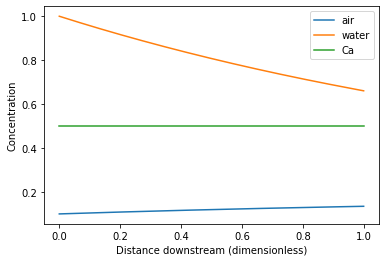

In [4]:
nx=1000
x = linspace(0,1,nx)
plot(x,C_a[936,:])
plot(x,C_w[936,:])
plot(x,C_Ca[936,:])
#plot(x,C_a[160,:])
#plot(x,C_w[160,:])
#plot(x,C_a[260,:])
#plot(x,C_w[260,:])
#plot(x,C_a[360,:])
#plot(x,C_w[360,:])

legend(['air','water', 'Ca'])
#Can compare against previous solution for D
#plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration');

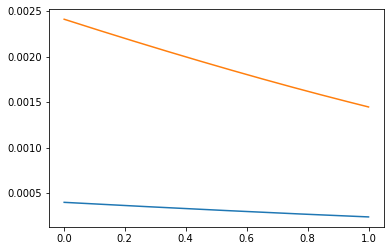

In [6]:
plot(x[1:],R_Ca)
plot(x[1:],R_CO2)
#plot(x,F)



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from CO2_transport_solver import calc_steady_adv_reaction

In [4]:
C_w, C_a, C_Ca, R = calc_steady_adv_reaction(1., 1.)

n= 0
rel tol C_w= 0.0009009009009007807   abs_tol_C_w= 0.0009009009009007807
rel tol C_a= 0.009009009009001978   abs_tol_C_a= 0.0009009009009001978
n= 1
rel tol C_w= 0.0008999080255347005   abs_tol_C_w= 0.0008990972975838618
rel tol C_a= 0.008910696410696578   abs_tol_C_a= 0.0008990972954937004
n= 2
rel tol C_w= 0.0008989154375684475   abs_tol_C_w= 0.0008972973914022075
rel tol C_a= 0.008814315489251245   abs_tol_C_a= 0.0008972973009082202
n= 3
rel tol C_w= 0.0008979240455942701   abs_tol_C_w= 0.0008955020790374357
rel tol C_a= 0.008719810055163115   abs_tol_C_a= 0.0008955009099154282
n= 4
rel tol C_w= 0.0008969384257350002   abs_tol_C_w= 0.000893715907469228
rel tol C_a= 0.0086271260772593   abs_tol_C_a= 0.0008937081153009147
n= 5
rel tol C_w= 0.000895971828144331   abs_tol_C_w= 0.0008919520383926516
rel tol C_a= 0.008536211580063955   abs_tol_C_a= 0.0008919189098655217
n= 6
rel tol C_w= 0.0008950481011700844   abs_tol_C_w= 0.0008902341160884619
rel tol C_a= 0.008447016546922759   abs

n= 156
rel tol C_w= 0.000858464252609594   abs_tol_C_w= 0.0007499024565831292
rel tol C_a= 0.0001936977940666129   abs_tol_C_a= 2.6979476873162378e-05
n= 157
rel tol C_w= 0.0008582817596331862   abs_tol_C_w= 0.00074911220156193
rel tol C_a= 0.00019293681007517697   abs_tol_C_a= 2.6868276785135814e-05
n= 158
rel tol C_w= 0.0008580993286059444   abs_tol_C_w= 0.0007483229949000192
rel tol C_a= 0.0001921769374414553   abs_tol_C_a= 2.6757293866197518e-05
n= 159
rel tol C_w= 0.0008579172371081729   abs_tol_C_w= 0.0007475350017889237
rel tol C_a= 0.00019141817130010813   abs_tol_C_a= 2.6646527054419167e-05
n= 160
rel tol C_w= 0.0008577352039089186   abs_tol_C_w= 0.0007467481297870338
rel tol C_a= 0.0001906605070353927   abs_tol_C_a= 2.6535975324731842e-05
n= 161
rel tol C_w= 0.0008575532956547596   abs_tol_C_w= 0.0007459623748373723
rel tol C_a= 0.0001899039402380538   abs_tol_C_a= 2.6425637682875314e-05
n= 162
rel tol C_w= 0.0008573716531625171   abs_tol_C_w= 0.0007451778230904704
rel tol C_

n= 311
rel tol C_w= 0.0007822826801685808   abs_tol_C_w= 0.0006008971995501433
rel tol C_a= 8.990344835798188e-05   abs_tol_C_a= 1.2254404006650788e-05
n= 312
rel tol C_w= 0.0007808563134155866   abs_tol_C_w= 0.0005993323457000876
rel tol C_a= 8.93505376480919e-05   abs_tol_C_a= 1.217794387070592e-05
n= 313
rel tol C_w= 0.0007794126765758781   abs_tol_C_w= 0.0005977571807468385
rel tol C_a= 8.879954758596057e-05   abs_tol_C_a= 1.2101765824834576e-05
n= 314
rel tol C_w= 0.0007779517915625301   abs_tol_C_w= 0.0005961717537790179
rel tol C_a= 8.825048530217128e-05   abs_tol_C_a= 1.2025870619269963e-05
n= 315
rel tol C_w= 0.0007764736839576136   abs_tol_C_w= 0.0005945761163812513
rel tol C_a= 8.770335782683072e-05   abs_tol_C_a= 1.1950258991644258e-05
n= 316
rel tol C_w= 0.0007749783829933687   abs_tol_C_w= 0.0005929703226058569
rel tol C_a= 8.715817208644618e-05   abs_tol_C_a= 1.1874931666572275e-05
n= 317
rel tol C_w= 0.0007734659215344018   abs_tol_C_w= 0.0005913544289455341
rel tol C_a

n= 475
rel tol C_w= 0.0004040341720606685   abs_tol_C_w= 0.0002808394554283389
rel tol C_a= 2.6615012099436712e-05   abs_tol_C_a= 3.595873441647468e-06
n= 476
rel tol C_w= 0.00040156150847697123   abs_tol_C_w= 0.0002790079614047869
rel tol C_a= 2.6388676155303997e-05   abs_tol_C_a= 3.5651989893914493e-06
n= 477
rel tol C_w= 0.0003990950992645572   abs_tol_C_w= 0.0002771829309923257
rel tol C_a= 2.6163964660995768e-05   abs_tol_C_a= 3.534746430250424e-06
n= 478
rel tol C_w= 0.00039663504536313295   abs_tol_C_w= 0.0002753644129180888
rel tol C_a= 2.594086989063272e-05   abs_tol_C_a= 3.5045146766776725e-06
n= 479
rel tol C_w= 0.00039418144613482923   abs_tol_C_w= 0.00027355245481619495
rel tol C_a= 2.571938410975503e-05   abs_tol_C_a= 3.4745026405991197e-06
n= 480
rel tol C_w= 0.00039173439936268103   abs_tol_C_w= 0.00027174710323130125
rel tol C_a= 2.5499499553184034e-05   abs_tol_C_a= 3.4447092304157323e-06
n= 481
rel tol C_w= 0.00038929400125193876   abs_tol_C_w= 0.00026994840362404293

n= 646
rel tol C_w= 0.0001085791285885673   abs_tol_C_w= 7.250253954249608e-05
rel tol C_a= 5.376571614142709e-06   abs_tol_C_a= 7.247226373463533e-07
n= 647
rel tol C_w= 0.00010761401603465519   abs_tol_C_w= 7.185029377654306e-05
rel tol C_a= 5.3229212768717595e-06   abs_tol_C_a= 7.174871055615206e-07
n= 648
rel tol C_w= 0.00010665628682211542   abs_tol_C_w= 7.120318659870062e-05
rel tol C_a= 5.269772796978575e-06   abs_tol_C_a= 7.103193356561288e-07
n= 649
rel tol C_w= 0.00010570590159374036   abs_tol_C_w= 7.056118772841291e-05
rel tol C_a= 5.217121950341301e-06   abs_tol_C_a= 7.032187556710312e-07
n= 650
rel tol C_w= 0.00010476282094184483   abs_tol_C_w= 6.99242669139899e-05
rel tol C_a= 5.164964550350317e-06   abs_tol_C_a= 6.96184798754107e-07
n= 651
rel tol C_w= 0.00010382700541439127   abs_tol_C_w= 6.9292393935938e-05
rel tol C_a= 5.113296432059507e-06   abs_tol_C_a= 6.89216901023082e-07
n= 652
rel tol C_w= 0.00010289841551877929   abs_tol_C_w= 6.866553860873648e-05
rel tol C_a= 

n= 816
rel tol C_w= 2.091293378527783e-05   abs_tol_C_w= 1.3835606650913768e-05
rel tol C_a= 9.058485277409728e-07   abs_tol_C_a= 1.2204881691402214e-07
n= 817
rel tol C_w= 2.0698609344849413e-05   abs_tol_C_w= 1.3693527223690438e-05
rel tol C_a= 8.960727402625967e-07   abs_tol_C_a= 1.2073157421021996e-07
n= 818
rel tol C_w= 2.0486365691094373e-05   abs_tol_C_w= 1.35528331898227e-05
rel tol C_a= 8.86399257659317e-07   abs_tol_C_a= 1.1942811900533812e-07
n= 819
rel tol C_w= 2.0276184304605618e-05   abs_tol_C_w= 1.3413512093940483e-05
rel tol C_a= 8.768270635430944e-07   abs_tol_C_a= 1.181383142700998e-07
n= 820
rel tol C_w= 2.006804680517798e-05   abs_tol_C_w= 1.3275551576930056e-05
rel tol C_a= 8.673551481036659e-07   abs_tol_C_a= 1.168620238634066e-07
n= 821
rel tol C_w= 1.986193495243018e-05   abs_tol_C_w= 1.313893937626709e-05
rel tol C_a= 8.579824971906523e-07   abs_tol_C_a= 1.1559911106129306e-07
n= 822
rel tol C_w= 1.9657830644578705e-05   abs_tol_C_w= 1.3003663325128478e-05
rel 

78 0.500030760291264
79 0.5000311474673433
80 0.5000315344627988
81 0.5000319212776799
82 0.5000323079120361
83 0.5000326943659169
84 0.5000330806393719
85 0.5000334667324506
86 0.5000338526452027
87 0.5000342383776777
88 0.500034623929925
89 0.5000350093019943
90 0.5000353944939352
91 0.5000357795057973
92 0.5000361643376301
93 0.5000365489894834
94 0.5000369334614065
95 0.5000373177534494
96 0.5000377018656614
97 0.5000380857980923
98 0.5000384695507917
99 0.5000388531238092
100 0.5000392365171946
101 0.5000396197309975
102 0.5000400027652675
103 0.5000403856200544
104 0.5000407682954077
105 0.5000411507913772
106 0.5000415331080127
107 0.5000419152453638
108 0.5000422972034803
109 0.5000426789824118
110 0.5000430605822082
111 0.5000434420029191
112 0.5000438232445942
113 0.5000442043072835
114 0.5000445851910366
115 0.5000449658959032
116 0.5000453464219332
117 0.5000457267691764
118 0.5000461069376825
119 0.5000464869275013
120 0.5000468667386827
121 0.5000472463712765
122 0.500047

509 0.5001815618198201
510 0.5001818758275176
511 0.5001821896765645
512 0.5001825033670129
513 0.5001828168989154
514 0.5001831302723245
515 0.5001834434872926
516 0.500183756543872
517 0.5001840694421154
518 0.5001843821820752
519 0.5001846947638037
520 0.5001850071873535
521 0.5001853194527772
522 0.5001856315601272
523 0.500185943509456
524 0.5001862553008161
525 0.50018656693426
526 0.5001868784098404
527 0.5001871897276097
528 0.5001875008876204
529 0.5001878118899252
530 0.5001881227345766
531 0.5001884334216271
532 0.5001887439511294
533 0.5001890543231361
534 0.5001893645376997
535 0.5001896745948728
536 0.5001899844947081
537 0.5001902942372581
538 0.5001906038225755
539 0.500190913250713
540 0.5001912225217232
541 0.5001915316356588
542 0.5001918405925724
543 0.5001921493925167
544 0.5001924580355444
545 0.5001927665217082
546 0.5001930748510608
547 0.5001933830236548
548 0.500193691039543
549 0.5001939988987781
550 0.500194306601413
551 0.5001946141475002
552 0.500194921537

947 0.5003046575600382
948 0.5003049072129605
949 0.500305156730333
950 0.5003054061121889
951 0.5003056553585604
952 0.5003059044694796
953 0.500306153444978
954 0.500306402285086
955 0.5003066509898338
956 0.5003068995592509
957 0.500307147993366
958 0.5003073962922073
959 0.5003076444558024
960 0.500307892484178
961 0.5003081403773599
962 0.5003083881353737
963 0.5003086357582439
964 0.5003088832459944
965 0.5003091305986481
966 0.5003093778162274
967 0.5003096248987536
968 0.5003098718462473
969 0.5003101186587283
970 0.5003103653362155
971 0.5003106118787269
972 0.5003108582862795
973 0.5003111045588896
974 0.5003113506965723
975 0.500311596699342
976 0.500311842567212
977 0.5003120883001942
978 0.5003123338983001
979 0.5003125793615398
980 0.5003128246899224
981 0.5003130698834558
982 0.5003133149421468
983 0.5003135598660011
984 0.5003138046550233
985 0.5003140493092166
986 0.5003142938285833
987 0.500314538213124
988 0.5003147824628382
989 0.5003150265777243
990 0.5003152705577

n= 919
rel tol C_w= 1.1486956295876269e-05   abs_tol_C_w= 7.588447207607096e-06
rel tol C_a= 1.076126228153072e-06   abs_tol_C_a= 1.4498127812179185e-07
rel tol C_Ca= 3.358993232157544e-08   abs_tol_C_Ca= 1.6798322177713487e-08
n= 920
rel tol C_w= 1.141192702153716e-05   abs_tol_C_w= 7.538795199768522e-06
rel tol C_a= 1.1021510221493146e-06   abs_tol_C_a= 1.4848731286210004e-07
rel tol C_Ca= 3.3566578363037305e-08   abs_tol_C_Ca= 1.678670169535934e-08
n= 921
rel tol C_w= 1.1337686884912056e-05   abs_tol_C_w= 7.489666197235678e-06
rel tol C_a= 1.1284676685819003e-06   abs_tol_C_a= 1.5203265588126236e-07
rel tol C_Ca= 3.3543793072127935e-08   abs_tol_C_Ca= 1.6775353550713135e-08
n= 922
rel tol C_w= 1.1264228188697754e-05   abs_tol_C_w= 7.441055080437131e-06
rel tol C_a= 1.1550727480416954e-06   abs_tol_C_a= 1.5561684604814552e-07
rel tol C_Ca= 3.3521494202214046e-08   abs_tol_C_Ca= 1.6764260313273383e-08
n= 923
rel tol C_w= 1.1191543305327636e-05   abs_tol_C_w= 7.392956776541837e-06
rel 

In [8]:
max([C_w,C_a])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
C_Ca[942,-10:]

array([0.50031472, 0.50031497, 0.50031522, 0.50031546, 0.50031571,
       0.50031596, 0.50031621, 0.50031646, 0.50031671, 0.50031696])